# Global networks

## Base model

In [1]:
from main import *
from training_evaluation import *
from rwnet_variations import *
from global_pfd import *

In [2]:
#We define our training function
train = lambda obj, max_episodes = 150, policy = None : sarsa(obj, world_generator=dense_world, policy= policy, decay_factor=0.95, threshold=max_episodes-100, max_episodes=max_episodes, episode_duration=300)

In [3]:
#We have a number of worlds set aside for comparison
test_worlds = [dense_world() for i in range(50)]

#On each world we shall run an episode - this is our test function applied to the world and network. 
#We must allow custom policies (e.g. softmax).
test_single_world = lambda world, inet, policy: run_episode(world, inet, epsilon = 0, episode_duration = 300, policy=policy)

#To aggregate results we run our tests not on one world but many. 
#This allows us to compare agents after training in an exhaustive manner.
test = lambda inet, policy = None: [sum(test_single_world(world, inet, policy).rewards) for world in test_worlds]

In [4]:
#The GlobalNet model is defined by a CNN, a global pathfinder, and a local pathfinder. It also requires us to specify the size of the local map, and that we use a directionalized local map.
global_cnn = GlobalConvolutionNet() # a two-layer CNN
global_pfd = BaseGlobalPathfinder(radius = 4) # similar to rwnet but adjusted to account for the non-directionalized data
local_pfd = SimpleLocalPathfinderNetWithDropout(radius = 7, dropout = 0.1) #rwnet with 10% dropout

base_global_pfd_nn = GlobalNet(global_cnn, global_pfd, local_pfd, (15,15), directional=True).to(device)
base_global_pfd_fm = gnet_fm
base_global_pfd = ModelPair(base_global_pfd_nn, base_global_pfd_fm, 'base_global_pfd', True)
base_global_pfd_gen = lambda : ModelPair(
    GlobalNet(
        GlobalConvolutionNet(), 
        BaseGlobalPathfinder(radius = 4), 
        SimpleLocalPathfinderNetWithDropout(radius = 7, dropout = 0.1), 
        (15,15), directional=True
    ).to(device), 
    base_global_pfd_fm, 
    'base_global_pfd', 
    True)

In [5]:
print(base_global_pfd_nn)

GlobalNet(
  (pw_conv): Tile3LayerConvolution(
    (conv_layers): Sequential(
      (0): Conv2d(3, 6, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (1): ELU(alpha=1.0)
      (2): Conv2d(6, 1, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (3): ELU(alpha=1.0)
    )
  )
  (global_conv): GlobalConvolutionNet(
    (conv_layers): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(7, 7), padding=valid)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=valid)
      (4): ELU(alpha=1.0)
    )
    (positional_convolution): Conv2d(1, 1, kernel_size=(7, 7), stride=(7, 7), padding=valid)
    (merge_layer): Sequential(
      (0): Conv2d(2, 6, kernel_size=(1, 1), stride=(1, 1))
      (1): ELU(alpha=1.0)
      (2): Conv2d(6, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (global_pathfinder): BaseGlobalPathfinder(
    (layers): Sequen

In [6]:
X = test_initialize_model(base_global_pfd)

Model internal state initialized...
Model feature computed...
Feature type: <class 'tuple'>
Model outcome on initial state: tensor([[-0.1905, -0.1894, -0.1842, -0.1951]], device='cuda:0')
Total number of parameters: 17552
Model passed


In [7]:
rewards_df_base, test_rewards_df_base = run_training(base_global_pfd_gen, train, test)

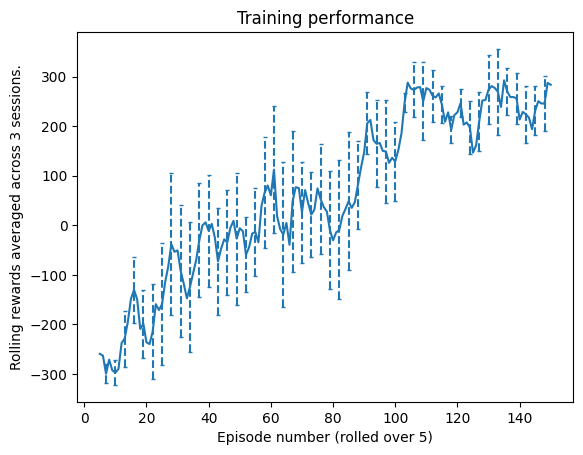

In [8]:
rolled_df_base = roll_training_data(rewards_df_base)
plot_training(rolled_df_base, 150)
plt.savefig('global_base_training.png')
plt.show()

In [9]:
#We print the performance:
perf_base, mean_base, err_base = metrics(test_rewards_df_base)

             Mean       Err.
Session 0  440.72  33.979454
Session 1  250.22  39.891980
Session 2  446.56  36.274522


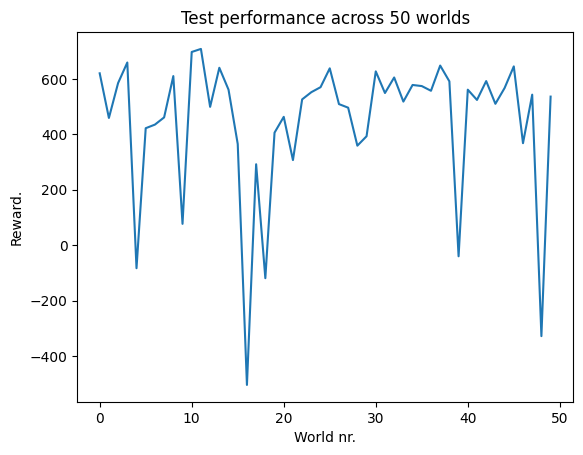

In [10]:
#We plot the best performer:
plot_test(test_rewards_df_base, perf_base)

The model appears to perform about as well as 'rwnet' or 'wnet+' in tests, though in training it appears to still be learning by the final episodes. Prolonging training might therefore be very beneficial.

## Longer training

In [11]:
#We define our training function for double the training length. This takes significantly longer to run.
train_long = lambda obj, max_episodes = 300, policy = None : sarsa(obj, world_generator=dense_world, policy= policy, decay_factor=0.95, threshold=max_episodes-100, max_episodes=max_episodes, episode_duration=300)

In [12]:
rewards_df_base_long, test_rewards_df_base_long = run_training(base_global_pfd_gen, train_long, test)

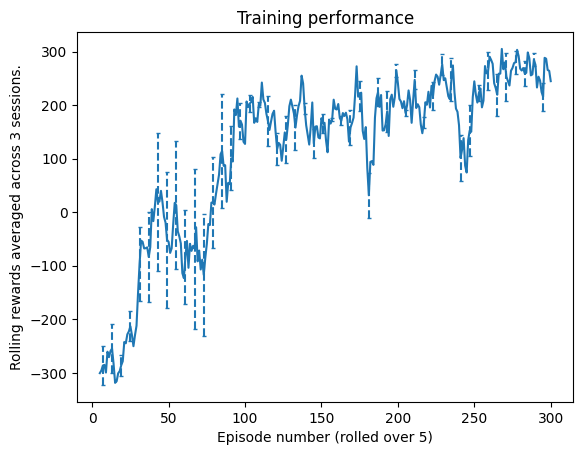

In [13]:
rolled_df_base_long = roll_training_data(rewards_df_base_long)
plot_training(rolled_df_base_long, 300)
plt.savefig('global_base_long_training.png')
plt.show()

More training does not appear to make a huge difference.

In [14]:
#We print the performance:
perf_base_long, mean_base_long, err_base_long = metrics(test_rewards_df_base_long)

             Mean       Err.
Session 0  410.02  38.462423
Session 1   79.98  59.517752
Session 2  377.98  30.196979


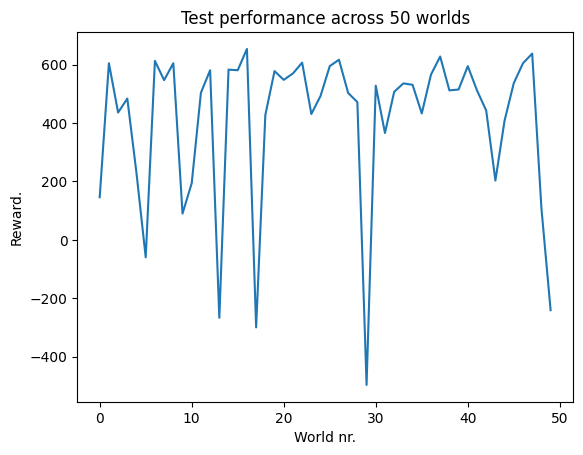

In [15]:
#We plot the best performer:
plot_test(test_rewards_df_base_long, perf_base_long)

## Transfer learning
We first train an ANN using only the local map, then save its weights and transfer them to the local pathfinder used in a global net. We could have frozen these but hopefully it suffices to give the local pathfinder a 'good' initialization to steer training towards a better minimum.

In [18]:
local_pfd = ModelPair(rw.LocalNet(SimpleLocalPathfinderNetWithDropout(7, dropout=0.1), radius = 7).to(device), gnet_fm, 'rwnet_for_global', True)

In [19]:
outcome = train(local_pfd)

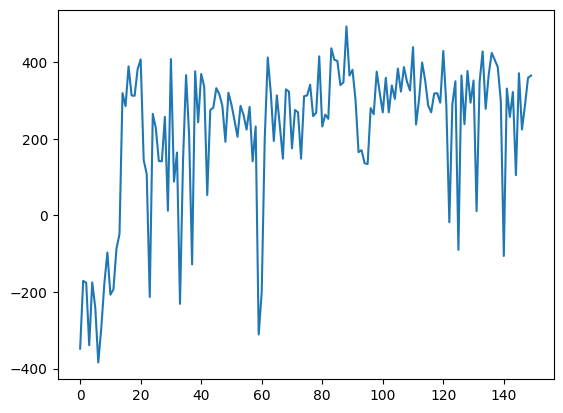

In [47]:
#We check that the local pathfinder does OK - doesn't need to be great but would be silly to use if it is really bad
plt.plot(outcome)

Pretty typical performance.

In [31]:
torch.save(local_pfd.nn_model.local_pathfinder.state_dict(), 'local_pfd.pth')

In [21]:
#Only applied first time this is run:
#local_pfd.save()

In [52]:
#Define our generator (this one is complex so easier to do as a concrete function rather than a lambda-definition)
def transf_learning_global_pfd_gen():
    gcn = GlobalConvolutionNet()
    gpfd = BaseGlobalPathfinder(radius = 4)
    lpfd = SimpleLocalPathfinderNetWithDropout(radius = 7, dropout = 0.1)
    lpfd.load_state_dict(torch.load('local_pfd.pth', weights_only=True))   
    gnet_model = GlobalNet(gcn, gpfd, lpfd, (15,15), directional=True).to(device)
    return ModelPair(gnet_model, gnet_fm, 'transf_global_pfd', True)

In [53]:
transf_model = transf_learning_global_pfd_gen()

In [54]:
X = test_initialize_model(transf_model)

Model internal state initialized...
Model feature computed...
Feature type: <class 'tuple'>
Model outcome on initial state: tensor([[-32.9670, -34.0287, -35.3774, -34.1780]], device='cuda:0')
Total number of parameters: 17552
Model passed


In [55]:
rewards_df_base_transf, test_rewards_df_base_transf = run_training(transf_learning_global_pfd_gen, train, test)

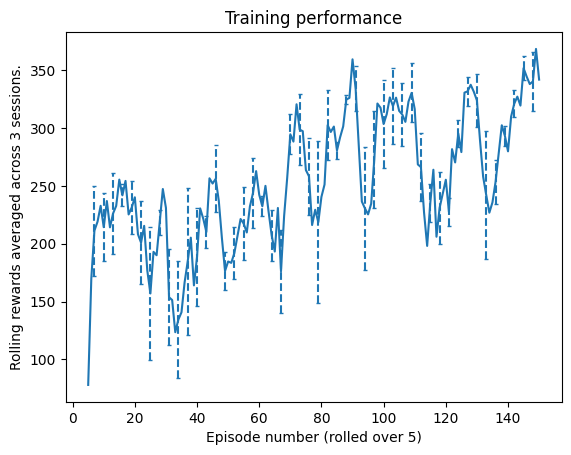

In [56]:
rolled_df_base_transf = roll_training_data(rewards_df_base_transf)
plot_training(rolled_df_base_transf, 150)
plt.savefig('global_base_transf_training.png')
plt.show()

In [57]:
#We print the performance:
perf_base_transf, mean_base_transf, err_base_transf = metrics(test_rewards_df_base_transf)

             Mean       Err.
Session 0  360.72  48.354170
Session 1  445.46  35.058589
Session 2  476.32  26.779987


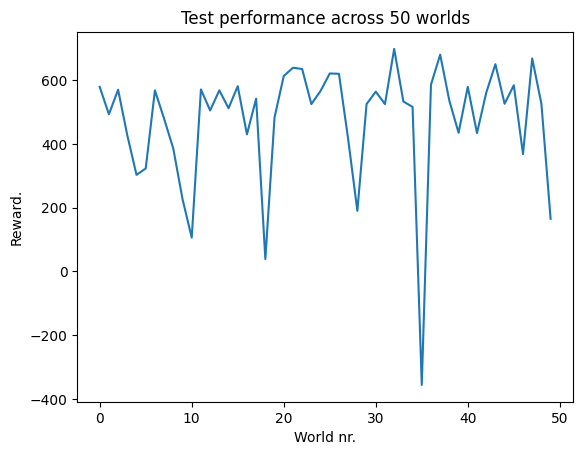

In [58]:
#We plot the best performer:
plot_test(test_rewards_df_base_transf, perf_base_transf)

## Comparison of above model training

#### Training performance

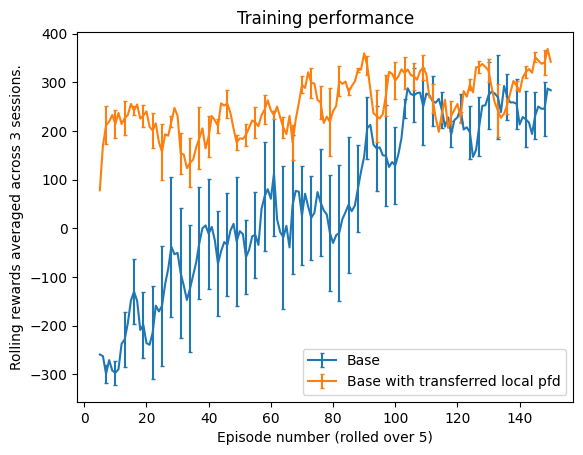

In [59]:
rolled_dfs = [rolled_df_base, rolled_df_base_transf]
names= ['Base', 'Base with transferred local pfd']
fp = multiplot_training(rolled_dfs, names, 150, sessions = 3, roll_nr = 5)
plt.savefig('global_training.png')
plt.show()

No real surprises. The transferred learning does not meaningfully impact the end result by the look of this,  though it is somewhat more stable.

#### Test performance: Best agents
We create a dataframe for the best performing agents within each architecture:

In [60]:
perf = pd.DataFrame()
perf['Means'] = [mean_base, mean_base_long, mean_base_transf]
perf['Std. Err'] =[err_base, err_base_long, err_base_transf]
perf.index = ['Base', 'Base with longer training', 'Base with transferred local pfd']
perf.to_csv("global_perf.csv")
perf

,Means,Std. Err
Base,446.56,36.274522
Base with longer training,410.02,38.462423
Base with transferred local pfd,476.32,26.779987


# Performance versus our base 'local-only' model
We compare our best model from above with the local-only model we used before ('rwnet' 10% dropout).

In [70]:
rwnet_gen_tiny_dropout = lambda : ModelPair(rw.LocalNet(SimpleLocalPathfinderNetWithDropout(7, dropout=0.1), radius = 7).to(device), gnet_fm, 'rwnet', True)

In [71]:
rewards_df_rwnet, test_rewards_df_rwnet = run_training(rwnet_gen_tiny_dropout, train, test)

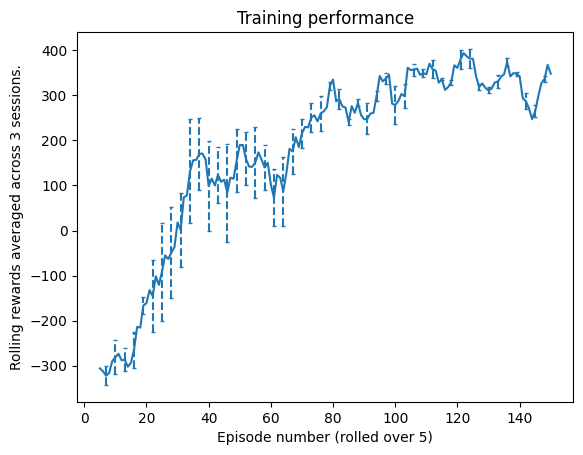

In [72]:
rolled_df_rwnet = roll_training_data(rewards_df_rwnet)
plot_training(rolled_df_rwnet, 150)
plt.show()

In [73]:
#We print the performance:
perf_rwnet, mean_rwnet, err_rwnet = metrics(test_rewards_df_rwnet)

             Mean       Err.
Session 0  476.86  25.078750
Session 1  401.62  30.175458
Session 2  510.50  36.451839


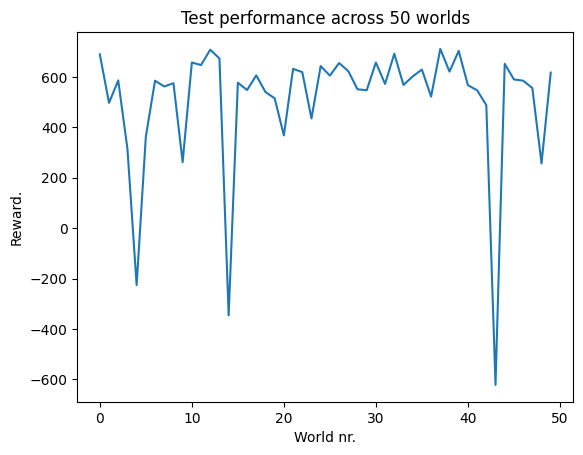

In [74]:
plot_test(test_rewards_df_rwnet, perf_rwnet)

### Comparing training

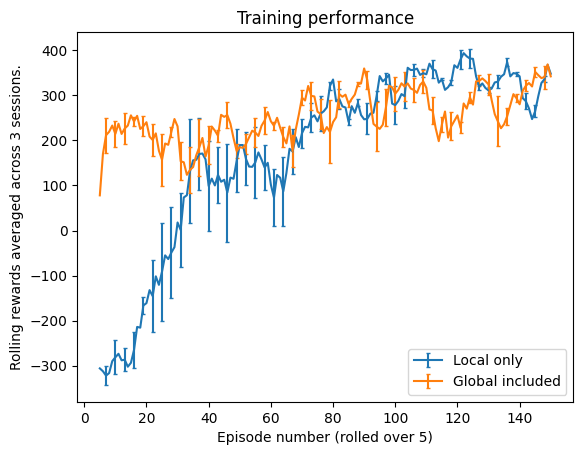

In [75]:
rolled_dfs = [rolled_df_rwnet, rolled_df_base_transf]
names= ['Local only', 'Global included']
fp = multiplot_training(rolled_dfs, names, 150, sessions = 3, roll_nr = 5)
plt.savefig('global_local_training.png')
plt.show()

### Comparing on test worlds

In [76]:
perf = pd.DataFrame()
perf['Means'] = [mean_rwnet, mean_base_transf]
perf['Std. Err'] =[err_rwnet, err_base_transf]
perf.index = ['Local only', 'Global included']
perf.to_csv("global_local_perf.csv")
perf

,Means,Std. Err
Local only,510.50,36.451839
Global included,476.32,26.779987


The agent using the global map to augment the local map does worse across our tests, at least in aggregate. Of course, having tested rwnet quite a few times at this point we know that this is a pretty high score for our tests. Indeed, in our first training we had a local-only performance mean of 477, only marginally better than this global net. Nonetheless we should not be tempted into thinking that the network using global data is as good as rwnet - clearly it performs worse here. Let's see if it ever did better in any test episode.

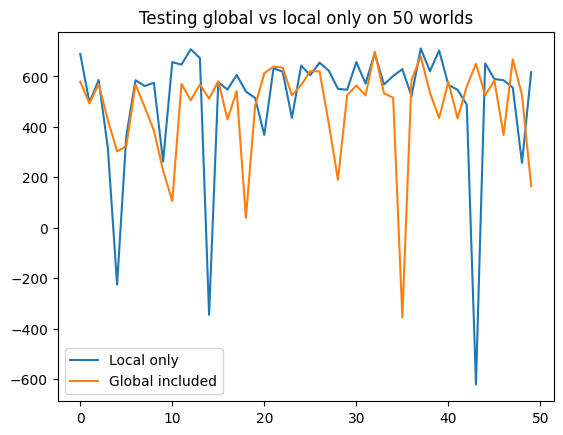

In [78]:
plt.plot(test_rewards_df_rwnet[perf_rwnet], label = "Local only")
plt.plot(test_rewards_df_base_transf[perf_base_transf], label = "Global included")
plt.legend()
plt.title("Testing global vs local only on 50 worlds")
plt.savefig('global_local_test_perf.png')
plt.show()

For a few episodes it does better, mostly it does worse, and it does have one catastrophic episode (rewards under 0). Still it is very noticeable that the global agent does appear to be less prone to really bad episodes.

## Qualitative look at global network
We train and save an agent using the transferred learning (this would have beenv vastly more effecient if we save agents in our test/training procedure, but alas we do not). We show how the agent thus trained performs on some world, to try to understand its typical behaviour, just as we did for the softmax example.

The interested reader can re-run the code below to get a running visualization of what the softmax policy agent does in an episode. 

The specific performance will of course vary as we do not fix seeds. Generally the agent appears to perform well, about the same as a the regular agent. It manages to avoid getting stuck most of the time.

As can be seen from the rewards plot, the agent trained in my case did have some difficulties, and did spend some time backtracking around step ~ 100 and step ~ 190. By the end it has a hard time as well, showing a typical flaw of these architectures when they cannot take global structures into account!

This will show:
- A title displaying the value $Q(S,:)$. These run by fast, so if you want to see them more closely, set 'pause = T' in the call 'plot_aug_episode' where T is the desired amount of time to watch each step, in seconds.
- The rewards plot for the episode
- The agents local map
- The internal visits state (i.e. the local map layer that tracks the number of visits to nearby positions)
- The agents full world map
- The features that are actually fed into the agent ('Seen', 'Terrain', 'Visits' which generally overlaps with the internal state) before pointwise convolution.
- The actual world map (which the agent does not have access to)
- The adjusted local map: The map after pointwise convolution which is fed into the ANN doing pathfinding. Note that this map is *learned* and so it will vary from session to session.
- **The augmented local map**: The map after the global pathfinder has augmented the boundary tiles in the local map. Again, this is a *learned* map.

Note that this requires running the first two blocks of code from above, and also note that training for the softmax policy does take some time due to an innefficient implementation. Therefore I have saved a trained agent which can be run without training (the first two code blocks still need to be run!), but the world will still be randomly generated.

In [79]:
base_transf = transf_learning_global_pfd_gen()
#Only run the first time
#train(base_transf)
#base_transf.save()
base_transf.load()

In [118]:
#Only run this the first time.
#world = dense_world()
#world_map_no_pad = world.world_map[WORLD_BOUNDARY_PADDING:-WORLD_BOUNDARY_PADDING, WORLD_BOUNDARY_PADDING:-WORLD_BOUNDARY_PADDING]
#np.save('global_illu', world_map_no_pad)
world = GridWorldEnvironment(np.load("global_illu.npy"), 9)

In [121]:
outcome = run_episode(world, base_transf, epsilon = 0, episode_duration = 300)

In [122]:
print(f"Total reward: {sum(outcome[2])}")

Total reward: 418


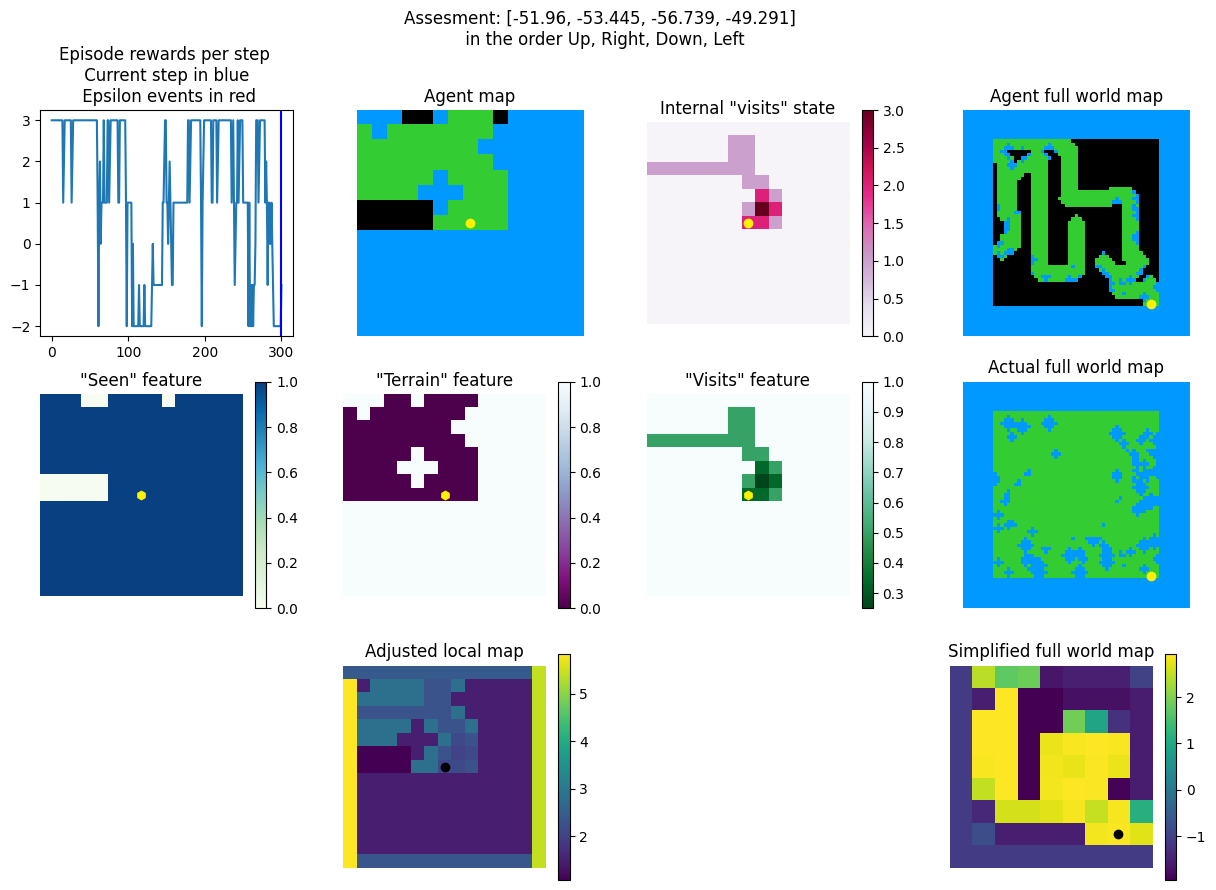

<Figure size 640x480 with 0 Axes>

In [123]:
plot_aug_episode(outcome, world.world_map)

The episode seen here is perhaps not typical (and of course, if you ran this again and generated a different world or trained a new agent it will not show the same results), but we sought to see a varied episode with some issues and without the agent getting completely locked in.

The agent must in this model infer its position in the global map from the simplified full world map (bottom right corner). But how this is to be achieved when the 'current tile the agent occupies' in the simplified global map is inferred is wholly unclear. While not definitive proof it seems unlikely that the global net gives any helpful structured information to the global network. Also note the 'lagging back and forth in episodes near ~100 and even more imporatantly at the end near ~290 - this is precisely the type of pattern we want the agent to avoid.

# Generalization potential
We deploy the usual rwnet agent, and compare its performance with that of the agent trained using the global model above. For another stab at a stochastic method we use the softmax agent as well.

In [186]:
rwnet = rwnet_gen_tiny_dropout()
rwnet.nn_model.pw_conv.load_state_dict(torch.load('pw_conv_pfd.pth', weights_only=True))
rwnet.nn_model.local_pathfinder.load_state_dict(torch.load('local_pfd.pth', weights_only=True))
glnet = base_transf
sm_rwnet = rw.rwnet_gen()
sm_rwnet.load()

In [164]:
softmax_policy = lambda feats, network, eps : eps_greedy(eps, softmax_choice(network(*feats)), mark_eps = True)

## 'Room world'
A world with only a few explorable tiles, all separated by thin corridors. This is about as bad an environment as possible for these agents to be deployed into.

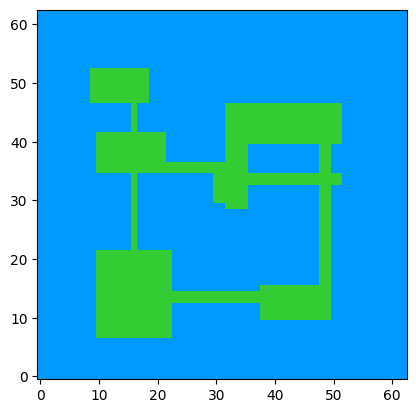

In [125]:
from rooms_map import *
room_world = GridWorldEnvironment(wmap_base, WORLD_BOUNDARY_PADDING)
plot_world(room_world)

In [129]:
print(f"Walkable tiles ~{69**2 - np.sum(room_world.world_map)}")

Walkable tiles ~1541


In [187]:
outcome_rwnet = run_episode(room_world, rwnet, epsilon = 0, episode_duration = 300)
print(f"Total reward for local-only agent: {sum(outcome_rwnet[2])}")

Total reward for local-only agent: -68


In [188]:
outcome_glnet = run_episode(room_world, glnet, epsilon = 0, episode_duration = 300)
print(f"Total reward for global and local agent: {sum(outcome_glnet[2])}")

Total reward for global and local agent: -310


In [189]:
random.seed(3141592)
outcome_sm = run_episode(room_world, sm_rwnet, policy=softmax_policy, epsilon = 0, episode_duration = 300)
print(f"Total reward for global and local agent: {sum(outcome_sm[2])}")

Total reward for global and local agent: 354


Clearly the softmax agent is enormously much better than the others. The numbers here cannot be compared to the ones found before however. Again a qualitative picture is more telling.

#### Qualitative picture for local only agent

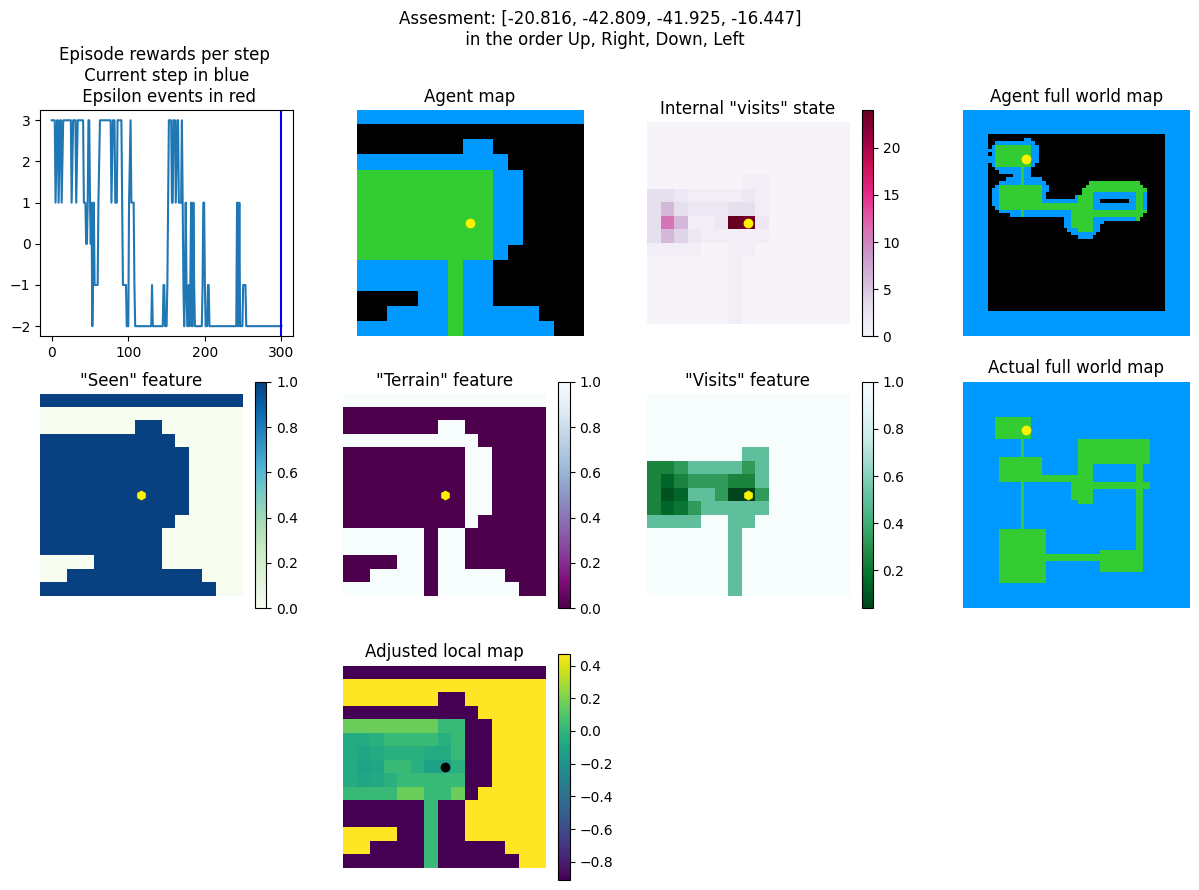

<Figure size 640x480 with 0 Axes>

In [190]:
plot_aug_episode(outcome_rwnet, room_world.world_map)

The agent does end up getting stuck, but manages a decent amount of exploration before this happens. Possibly this could've been avoided by using a non-normalized visits feature (notice that the visits feature is inversely proportional to the number of state visits, unlike the visits internals state). As it is the visits feature goes to zero in the tile the agent gets stuck in, and doesn't change much at all, preventing the agent from reassessing the tile value.

#### Qualitative picture for global agent

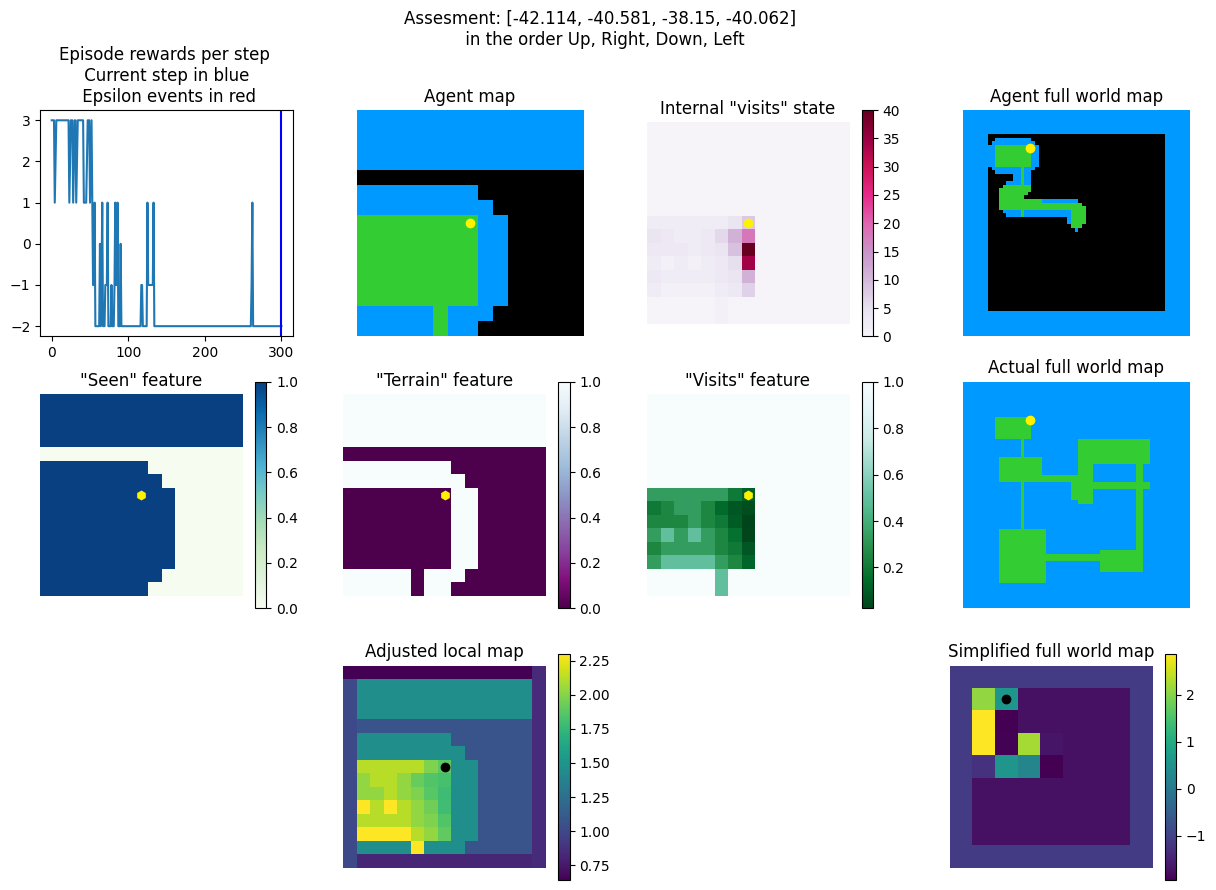

<Figure size 640x480 with 0 Axes>

In [155]:
plot_aug_episode(outcome_glnet, room_world.world_map)

Absolute disaster, though not quite as bad as trying to walk into water a bunch of times.

#### Qualitative picture for softmax agent

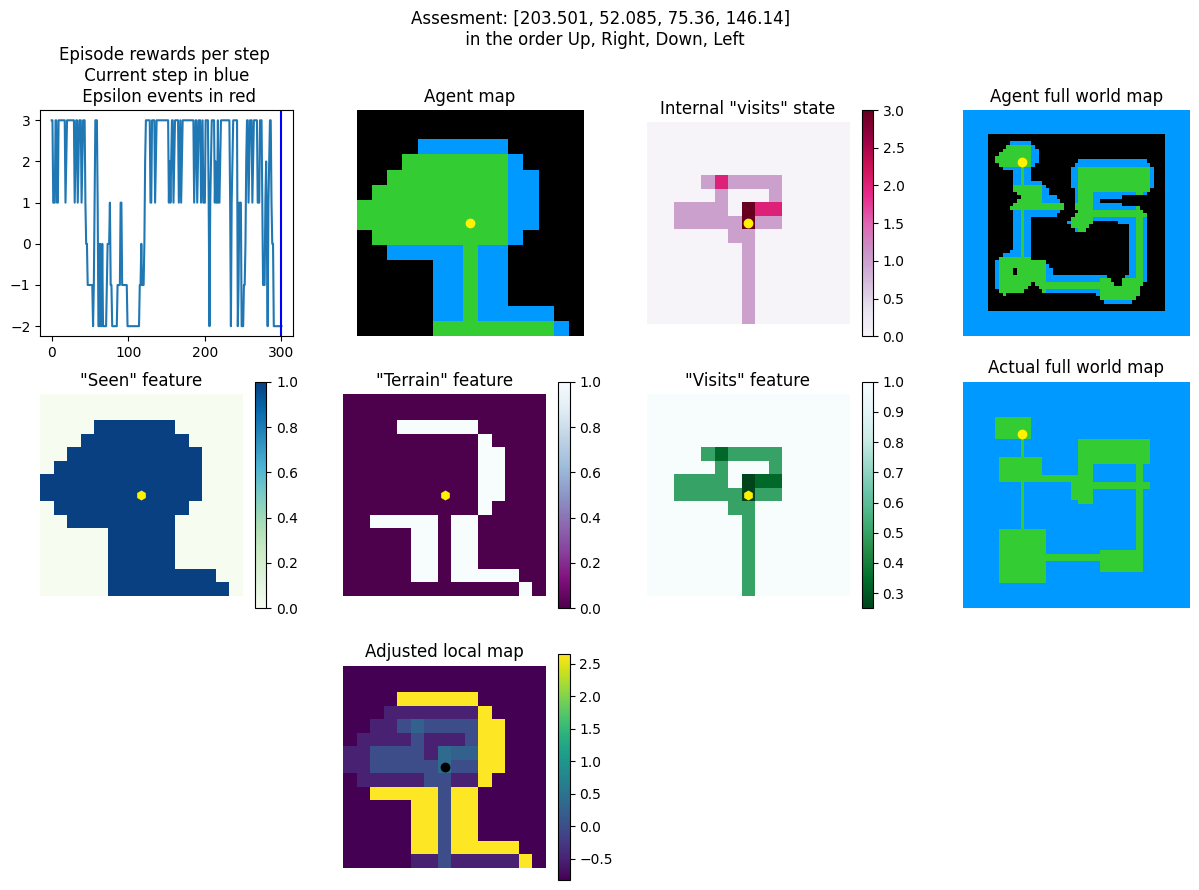

<Figure size 640x480 with 0 Axes>

In [168]:
plot_aug_episode(outcome_sm, room_world.world_map)

The agent gets a bot stuck in certain places but clearly moves around and explores far more than either of the previous two agents. It is clearly preferrable to acknowledge that the learned estimate of $Q$ (especially for this quite different setting) is not accurate enough to be treated as absolute, and it its better to treat it as a rough measure from which the agents acting stochastically are apparentl preferrable.

## Empty world
In this world the only water is the 'padding'. We also try to prolong the episode length, and see what the agents get up to in this simple setting.

In [157]:
empty_wmap = np.zeros((49,49), dtype =np.int8)
empty_world = GridWorldEnvironment(empty_wmap, WORLD_BOUNDARY_PADDING)

### Normal length episodes

In [200]:
outcome_rwnet_2n = run_episode(empty_world, rwnet, epsilon = 0, episode_duration = 300) 
print(f"Total reward for local-only agent: {sum(outcome_rwnet_2n[2])}")

Total reward for local-only agent: 735


In [201]:
outcome_glnet_2n = run_episode(empty_world, glnet, epsilon = 0, episode_duration = 300)
print(f"Total reward for global and local agent: {sum(outcome_glnet_2n[2])}")

Total reward for global and local agent: 655


In [202]:
random.seed(3141592)
outcome_sm_2n = run_episode(empty_world, sm_rwnet, policy=softmax_policy, epsilon = 0, episode_duration = 300)
print(f"Total reward for global and local agent: {sum(outcome_sm_2n[2])}")

Total reward for global and local agent: 693


### Prolonged episodes

In [203]:
outcome_rwnet_2 = run_episode(empty_world, rwnet, epsilon = 0, episode_duration = 600) 
print(f"Total reward for local-only agent: {sum(outcome_rwnet_2[2])}")

Total reward for local-only agent: 803


In [204]:
outcome_glnet_2 = run_episode(empty_world, glnet, epsilon = 0, episode_duration = 600)
print(f"Total reward for global and local agent: {sum(outcome_glnet_2[2])}")

Total reward for global and local agent: 57


In [205]:
random.seed(3141592)
outcome_sm_2 = run_episode(empty_world, sm_rwnet, policy=softmax_policy, epsilon = 0, episode_duration = 600)
print(f"Total reward for local only softmax agent: {sum(outcome_sm_2[2])}")

Total reward for local only softmax agent: 719


The softmax agent is quite close to the local only agent.

#### Qualitative picture for local only agent

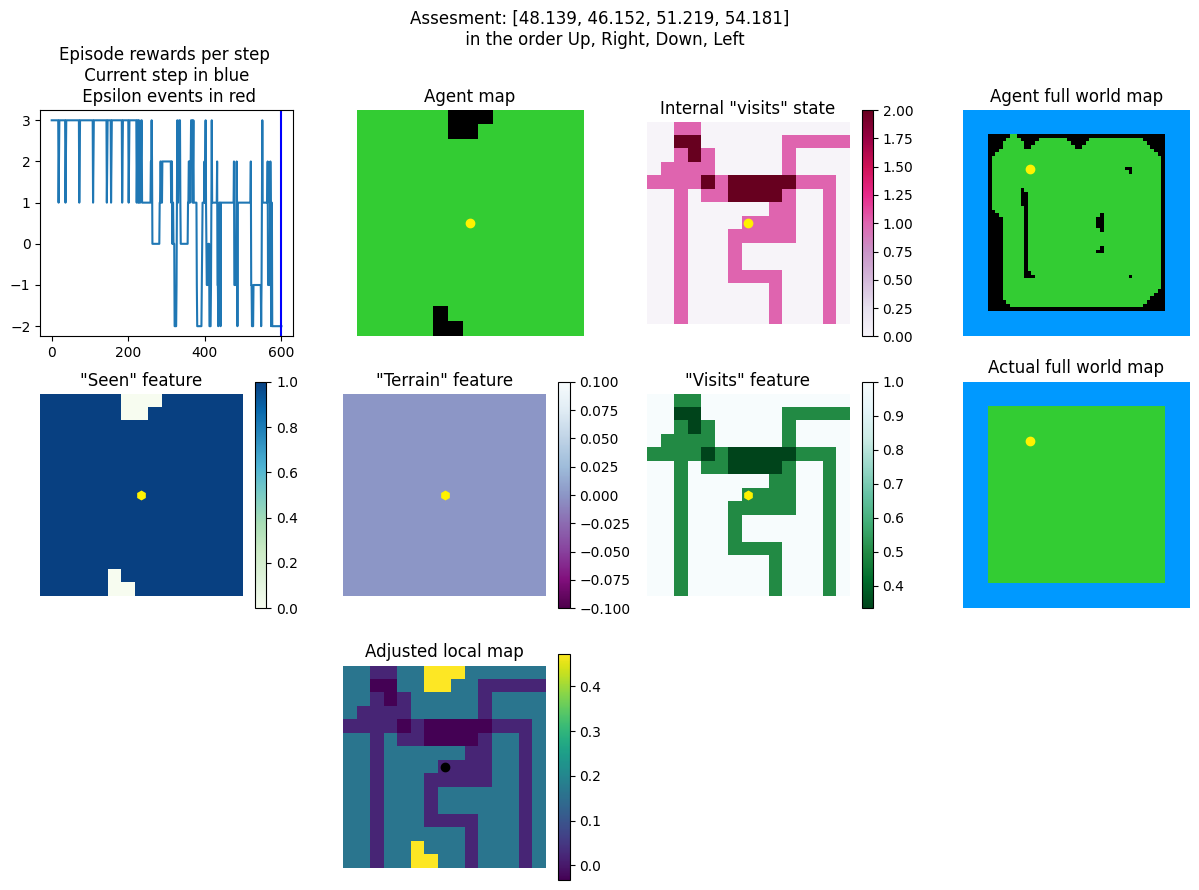

<Figure size 640x480 with 0 Axes>

In [198]:
plot_aug_episode(outcome_rwnet_2, empty_world.world_map)

#### Qualitative picture for global and local agent

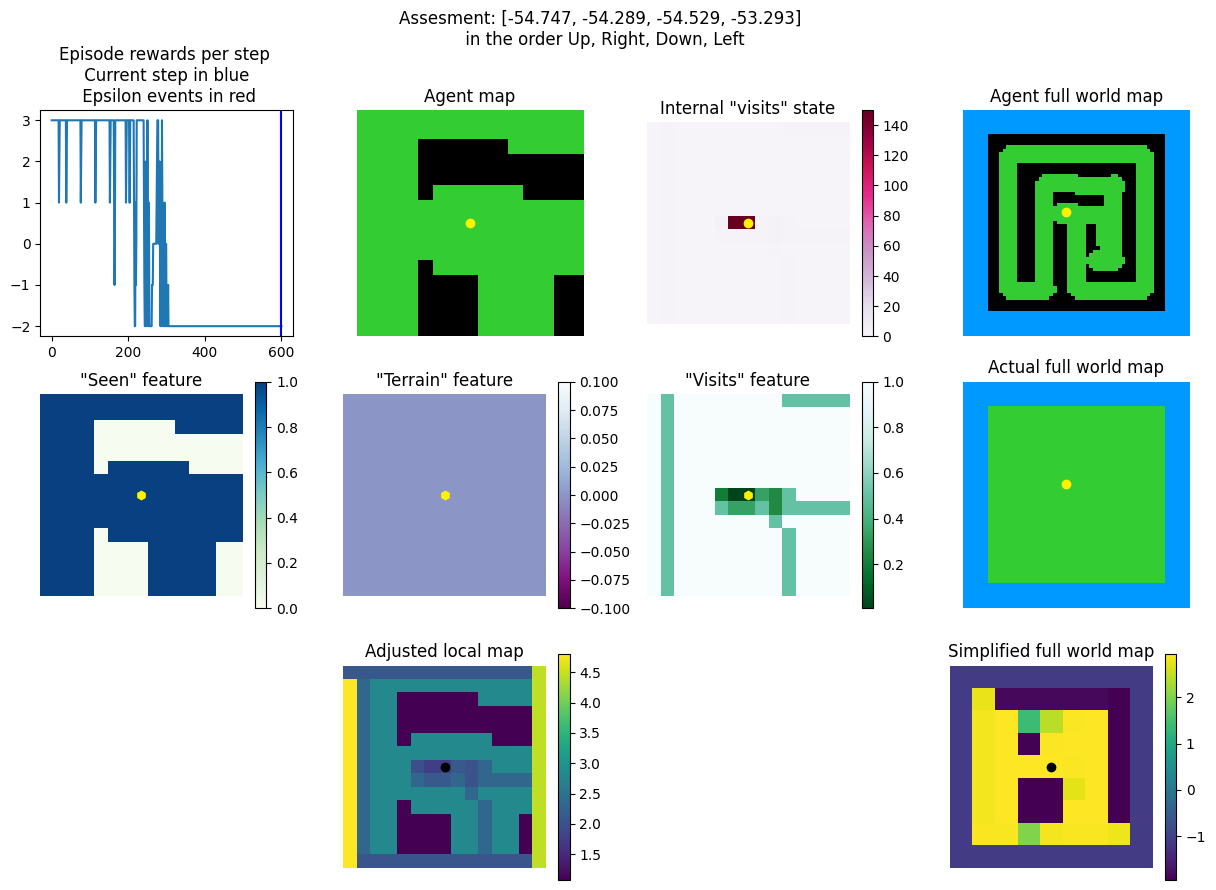

<Figure size 640x480 with 0 Axes>

In [162]:
plot_aug_episode(outcome_glnet_2, empty_world.world_map)

So apart from a period of decent exploration early on, the agent gets stuck. Clearly it is catastrophically affected by its ignorance of the normalized visits feature. As the visits go towards $\infty$ the visits feature slowly goes to zero - the agent does not 'react' to this, because the change is small. Possibly it would do better of ot trained more in environments where multiple visits to a tile are likely, but more likely it would be better to directly feed the internal visits state rather than the normalized visits feature.

#### Qualitative picture for softmax agent

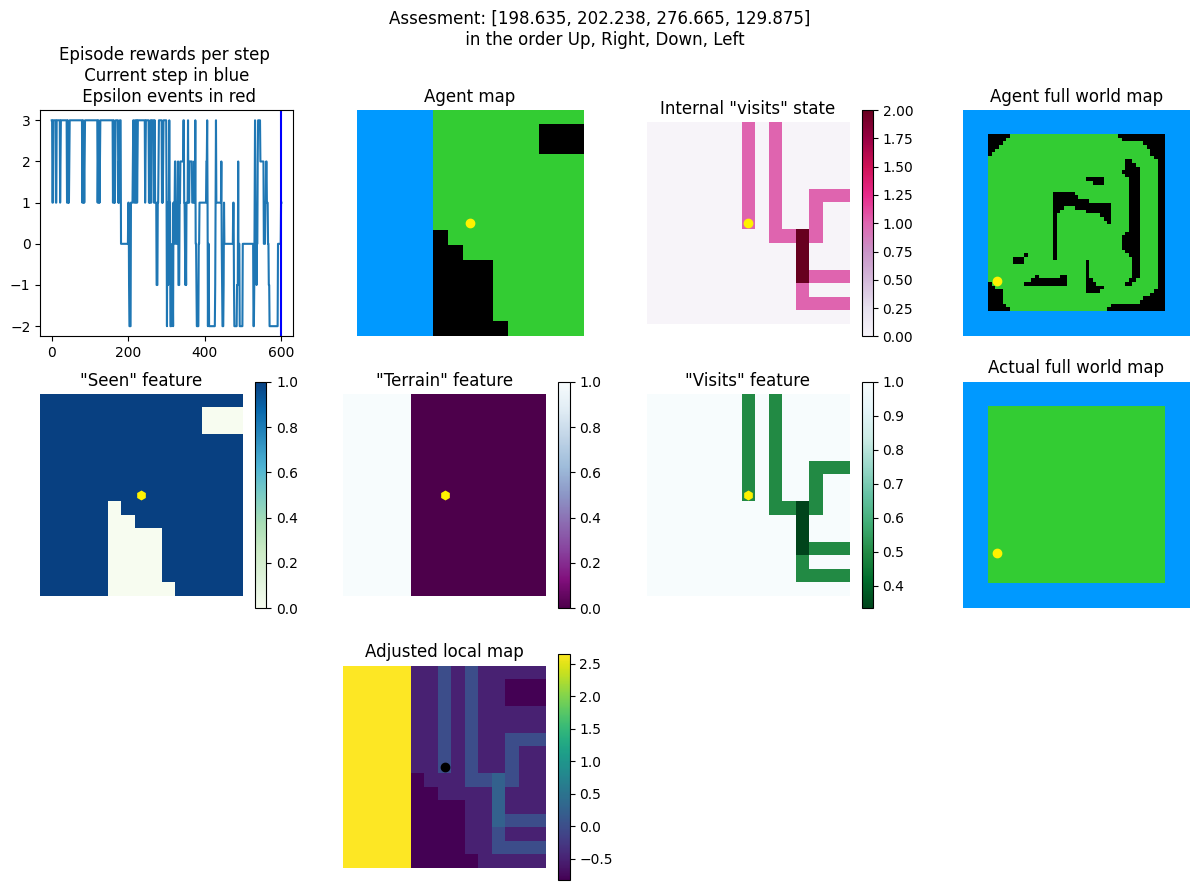

<Figure size 640x480 with 0 Axes>

In [170]:
plot_aug_episode(outcome_sm_2, empty_world.world_map)

The agent does pretty well, if a bit poorly at the end where it ends up in totally explored regions. Again a proper implementation of a network taking the full world map into account would be useful.